In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from ddpm import *


/nethome/zwang910/file_storage/miniconda3/envs/dl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 1. Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lr = 1e-4
num_epochs = 50
num_timesteps = 1000

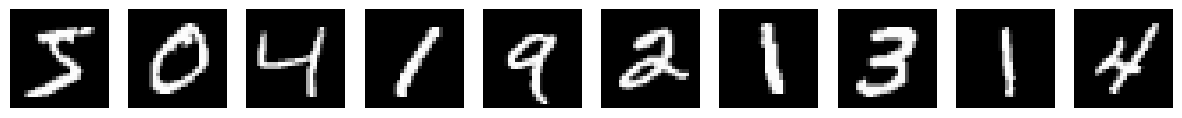

In [4]:
# laod MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# display first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(train_dataset.data[i] * 0.5 + 0.5, cmap='gray')
    axes[i].axis('off')
plt.show()


In [5]:
# split train set into 10 classes
def split_dataset_by_class(dataset):
    class_dict = {i: [] for i in range(10)}
    for img, label in tqdm(dataset):
        class_dict[label].append(img)
    return class_dict

class_dict = split_dataset_by_class(train_dataset)

100%|██████████| 60000/60000 [00:08<00:00, 7343.58it/s]


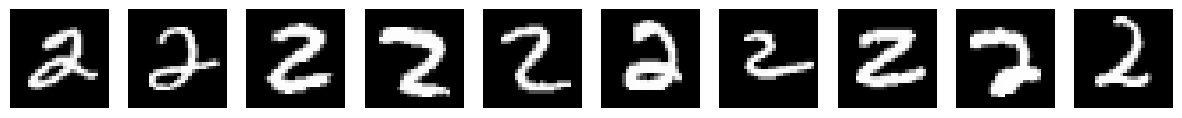

In [6]:
# display images of 2
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(class_dict[2][i].permute(1, 2, 0) * 0.5 + 0.5, cmap='gray')
    axes[i].axis('off')
plt.show()

In [7]:
# create DDPM-1, train on class 1 only
ddpm1_scheduler = NoiseScheduler(timesteps=1000, device=device)
unet_1 = UNet2DModel(
    sample_size=28, # MNIST images are 28x28
    in_channels=1,
    out_channels=1,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    layers_per_block=2,
    norm_num_groups=8
)
ddpm1 = DDPM(unet_1, ddpm1_scheduler, device=device)

# create DDPM-2, train on class 2 only
ddpm2_scheduler = NoiseScheduler(timesteps=1000, device=device)
unet_2 = UNet2DModel(
    sample_size=28, # MNIST images are 28x28
    in_channels=1,
    out_channels=1,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    layers_per_block=2,
    norm_num_groups=8
)
ddpm2 = DDPM(unet_2, ddpm2_scheduler, device=device)

In [39]:
def train(ddpm, class_data):

    train_loader = DataLoader(class_data, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(ddpm.unet.parameters(), lr=2e-4)
    num_epochs = 20
    step = 0

    for epoch in range(1, num_epochs+1):
        ddpm.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
        avg_loss = 0.0
        for data in pbar:
            # print(data)
            if isinstance(data, list):
                imgs, _ = data
            else:
                imgs = data
            imgs = imgs.to(device)
            loss = ddpm.training_loss(imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss = avg_loss * 0.9 + loss.item() * 0.1
            pbar.set_postfix(loss=avg_loss)
            step += 1
            # optional: save a checkpoint every few epochs
    # if step % 1000 == 0:
        # 5) Sampling example
        ddpm.eval()
        samples = ddpm.sample(batch_size=16, image_dim=(1, 28, 28))
        # display samples
        fig, axes = plt.subplots(2, 8, figsize=(8, 2))
        for i in range(16):
            axes[i//8, i%8].imshow(samples[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5, cmap='gray')
            axes[i//8, i%8].axis('off')
        plt.tight_layout()
        plt.show()
        ddpm.train()

Epoch 1/20: 100%|██████████| 53/53 [00:06<00:00,  8.00it/s, loss=0.0899]


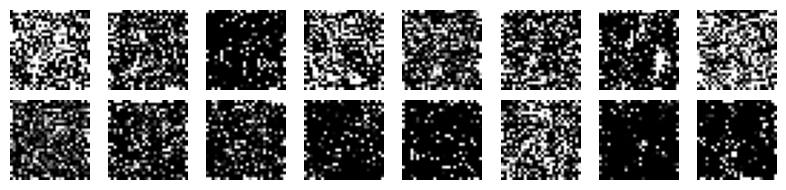

Epoch 2/20: 100%|██████████| 53/53 [00:02<00:00, 20.12it/s, loss=0.0507]


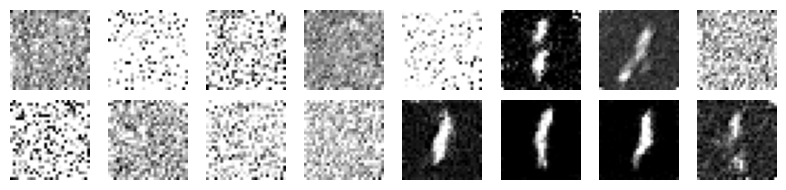

Epoch 3/20: 100%|██████████| 53/53 [00:02<00:00, 19.86it/s, loss=0.0371]


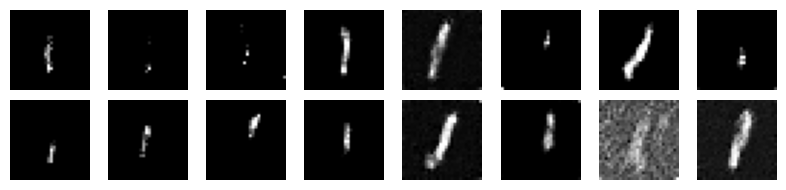

Epoch 4/20: 100%|██████████| 53/53 [00:02<00:00, 19.99it/s, loss=0.0312]


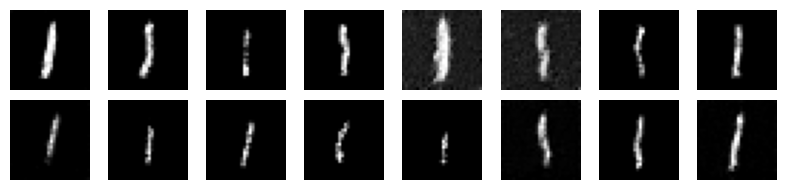

Epoch 5/20: 100%|██████████| 53/53 [00:02<00:00, 19.68it/s, loss=0.0267]


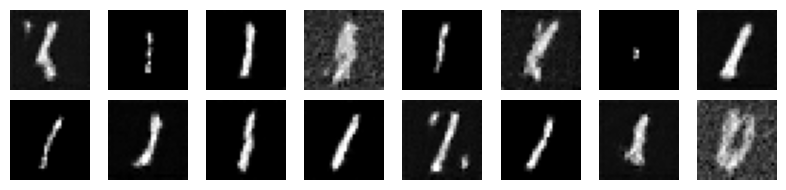

Epoch 6/20: 100%|██████████| 53/53 [00:02<00:00, 19.86it/s, loss=0.0253]


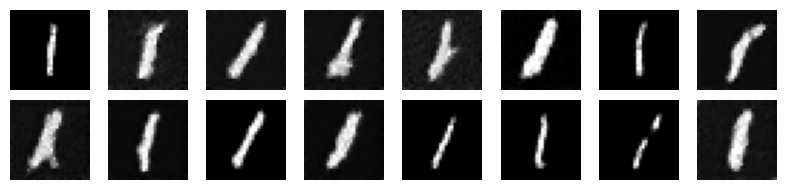

Epoch 7/20: 100%|██████████| 53/53 [00:02<00:00, 19.55it/s, loss=0.0232]


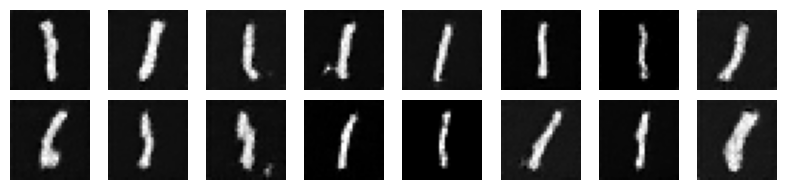

Epoch 8/20: 100%|██████████| 53/53 [00:02<00:00, 19.92it/s, loss=0.0223]


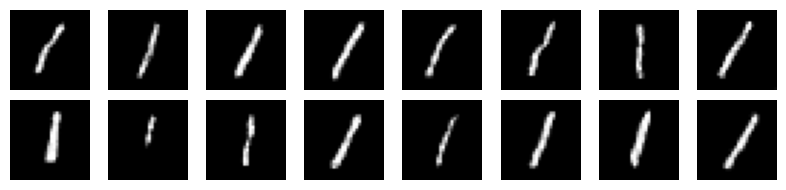

Epoch 9/20: 100%|██████████| 53/53 [00:02<00:00, 19.53it/s, loss=0.021] 


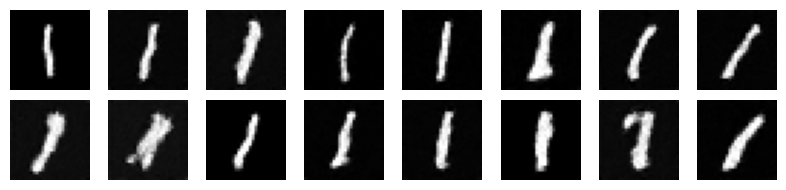

Epoch 10/20: 100%|██████████| 53/53 [00:02<00:00, 19.63it/s, loss=0.0212]


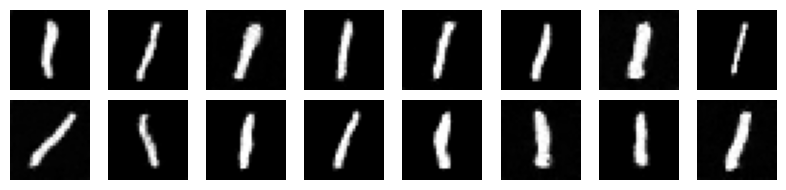

Epoch 11/20: 100%|██████████| 53/53 [00:02<00:00, 19.78it/s, loss=0.0194]


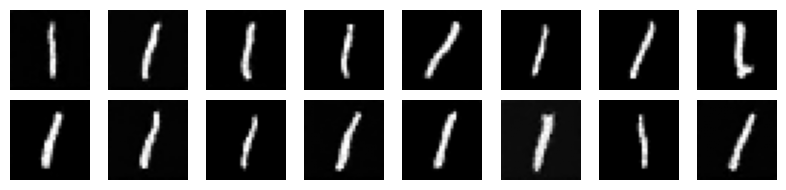

Epoch 12/20: 100%|██████████| 53/53 [00:02<00:00, 19.82it/s, loss=0.0201]


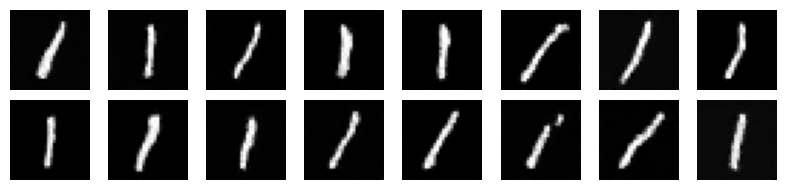

Epoch 13/20: 100%|██████████| 53/53 [00:02<00:00, 19.88it/s, loss=0.0194]


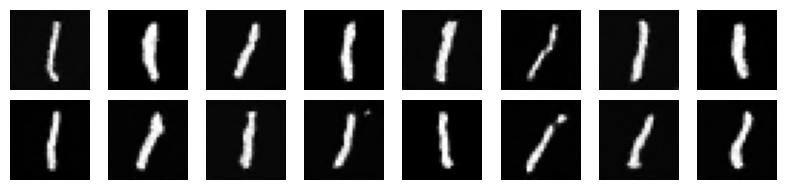

Epoch 14/20: 100%|██████████| 53/53 [00:02<00:00, 19.86it/s, loss=0.0173]


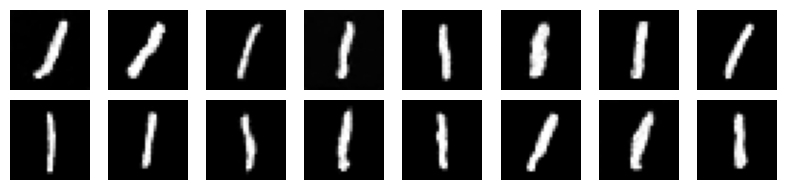

Epoch 15/20: 100%|██████████| 53/53 [00:02<00:00, 19.81it/s, loss=0.0168]


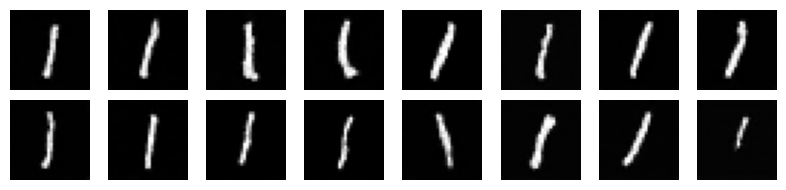

Epoch 16/20: 100%|██████████| 53/53 [00:02<00:00, 19.55it/s, loss=0.017] 


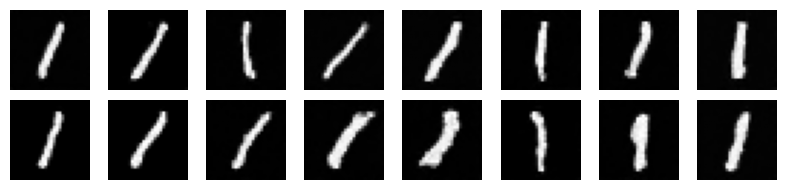

Epoch 17/20: 100%|██████████| 53/53 [00:02<00:00, 19.88it/s, loss=0.0172]


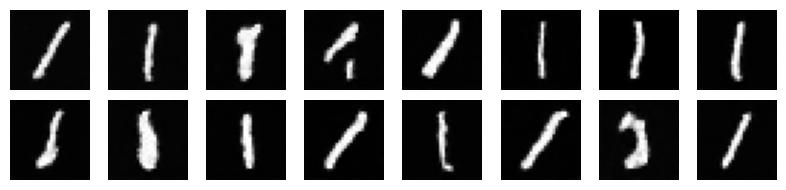

Epoch 18/20: 100%|██████████| 53/53 [00:02<00:00, 19.91it/s, loss=0.0172]


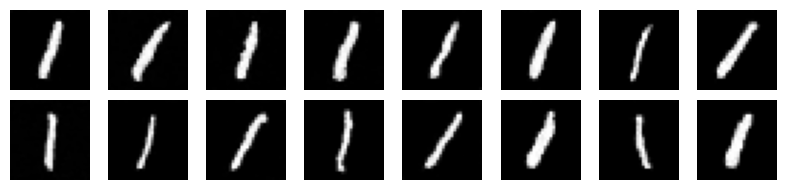

Epoch 19/20: 100%|██████████| 53/53 [00:02<00:00, 19.89it/s, loss=0.0179]


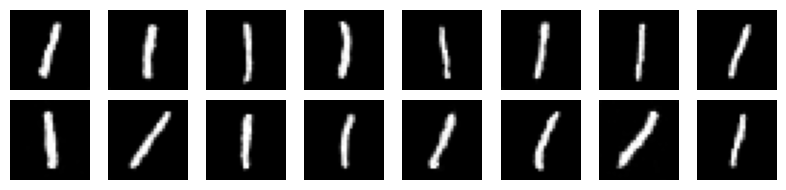

Epoch 20/20: 100%|██████████| 53/53 [00:02<00:00, 19.96it/s, loss=0.0156]


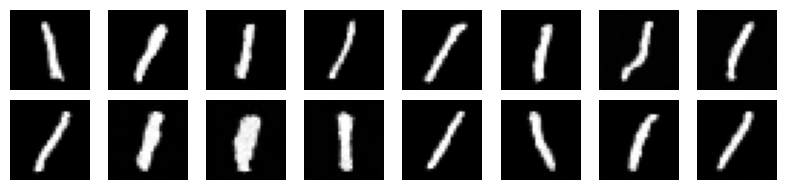

In [10]:
# train on class 1
train(ddpm1, class_dict[1])

Epoch 1/20: 100%|██████████| 47/47 [00:02<00:00, 19.10it/s, loss=0.139]


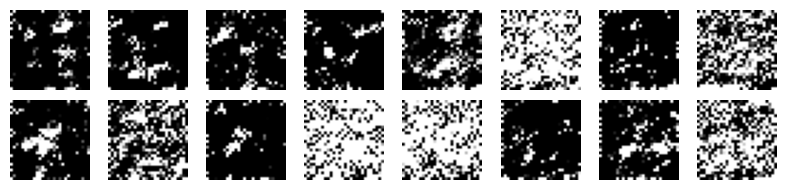

Epoch 2/20: 100%|██████████| 47/47 [00:02<00:00, 19.87it/s, loss=0.0831]


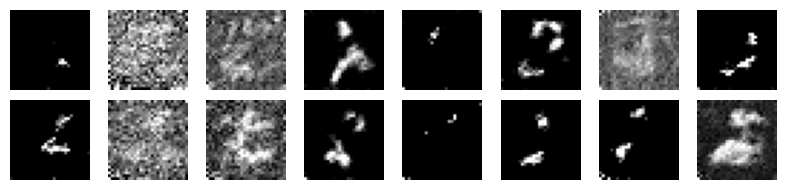

Epoch 3/20: 100%|██████████| 47/47 [00:02<00:00, 20.33it/s, loss=0.0603]


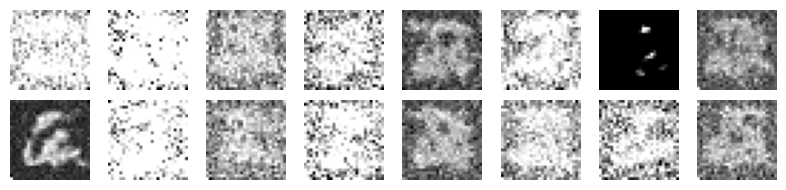

Epoch 4/20: 100%|██████████| 47/47 [00:02<00:00, 19.78it/s, loss=0.0538]


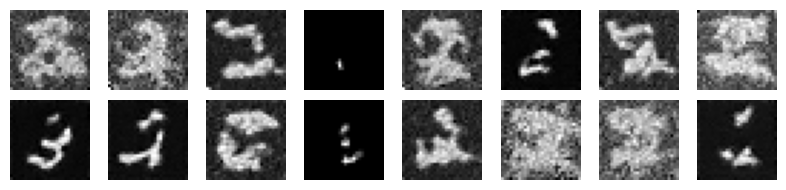

Epoch 5/20: 100%|██████████| 47/47 [00:02<00:00, 19.98it/s, loss=0.0492]


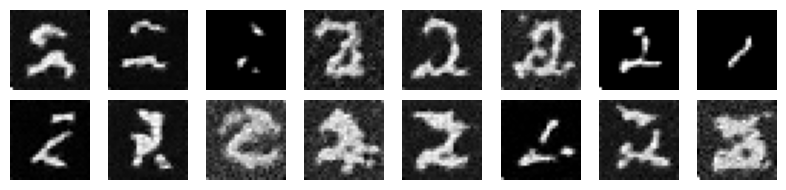

Epoch 6/20: 100%|██████████| 47/47 [00:02<00:00, 19.55it/s, loss=0.0446]


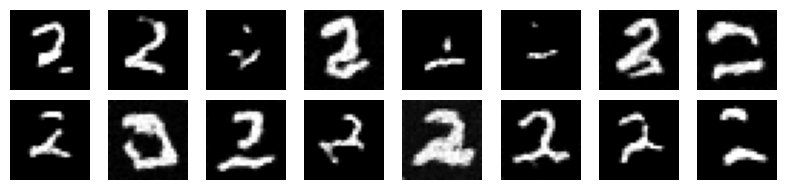

Epoch 7/20: 100%|██████████| 47/47 [00:02<00:00, 19.82it/s, loss=0.0435]


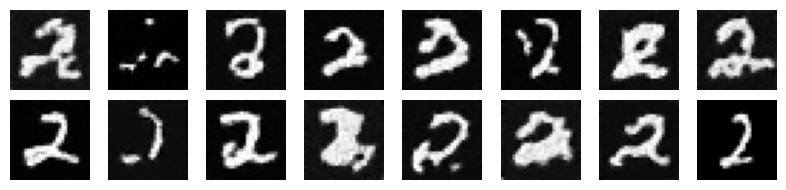

Epoch 8/20: 100%|██████████| 47/47 [00:02<00:00, 19.73it/s, loss=0.0369]


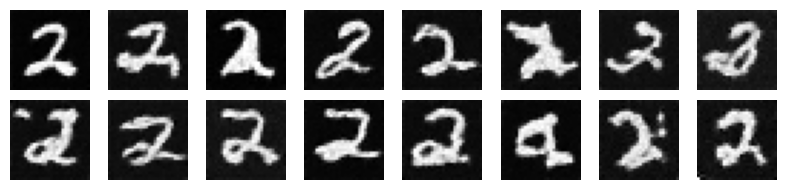

Epoch 9/20: 100%|██████████| 47/47 [00:02<00:00, 19.74it/s, loss=0.037] 


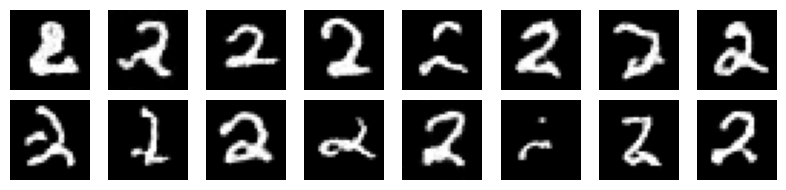

Epoch 10/20: 100%|██████████| 47/47 [00:02<00:00, 19.93it/s, loss=0.0358]


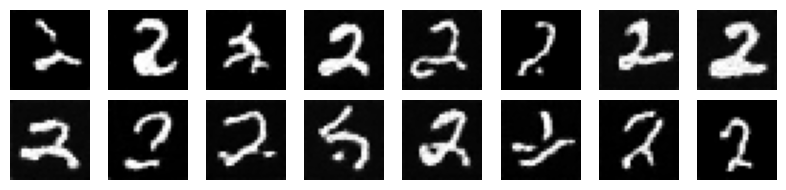

Epoch 11/20: 100%|██████████| 47/47 [00:02<00:00, 19.87it/s, loss=0.0364]


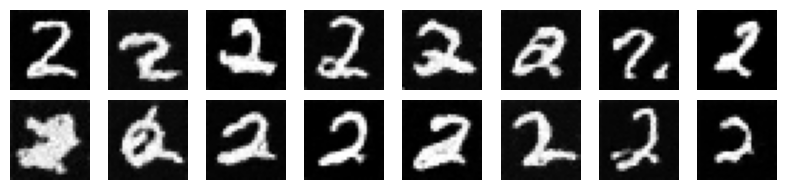

Epoch 12/20: 100%|██████████| 47/47 [00:02<00:00, 19.73it/s, loss=0.0333]


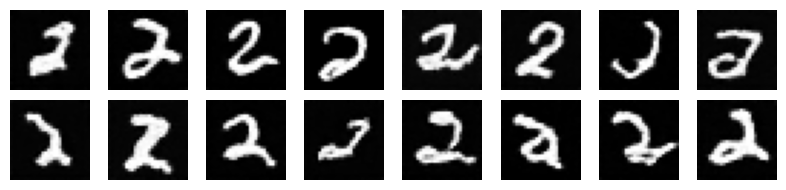

Epoch 13/20: 100%|██████████| 47/47 [00:02<00:00, 19.59it/s, loss=0.0348]


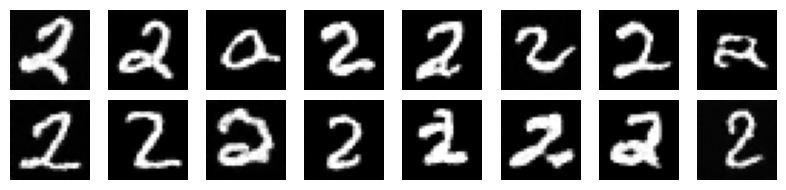

Epoch 14/20: 100%|██████████| 47/47 [00:02<00:00, 19.86it/s, loss=0.0342]


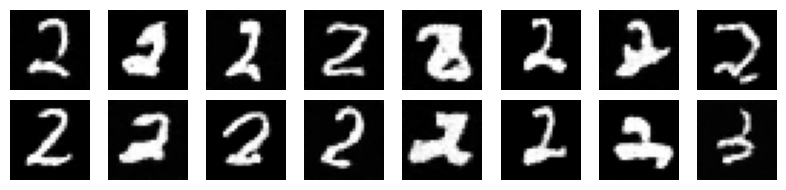

Epoch 15/20: 100%|██████████| 47/47 [00:02<00:00, 19.93it/s, loss=0.0335]


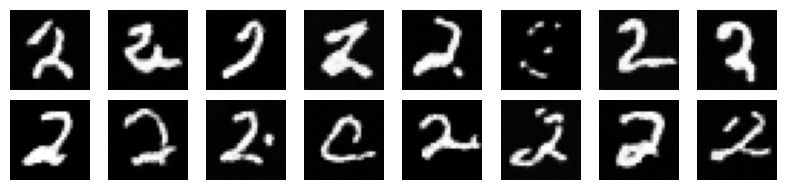

Epoch 16/20: 100%|██████████| 47/47 [00:02<00:00, 19.60it/s, loss=0.0322]


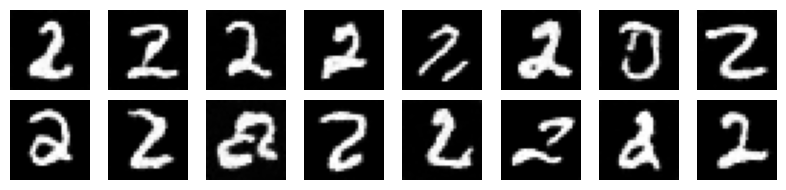

Epoch 17/20: 100%|██████████| 47/47 [00:02<00:00, 19.84it/s, loss=0.03]  


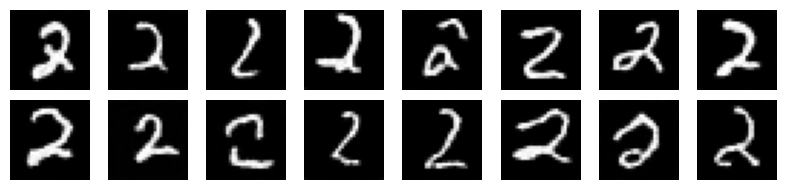

Epoch 18/20: 100%|██████████| 47/47 [00:02<00:00, 19.81it/s, loss=0.0315]


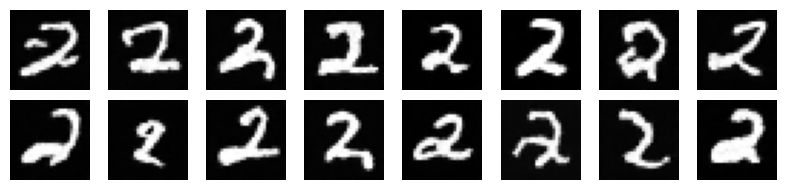

Epoch 19/20: 100%|██████████| 47/47 [00:02<00:00, 19.98it/s, loss=0.0282]


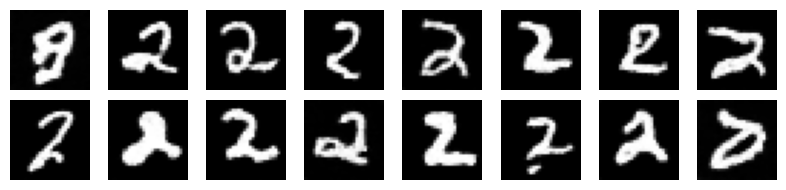

Epoch 20/20: 100%|██████████| 47/47 [00:02<00:00, 19.70it/s, loss=0.0315]


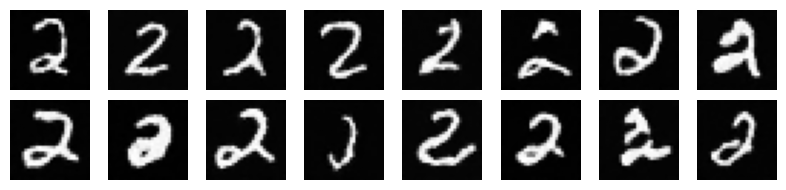

In [11]:
# train on class 2
train(ddpm2, class_dict[2])

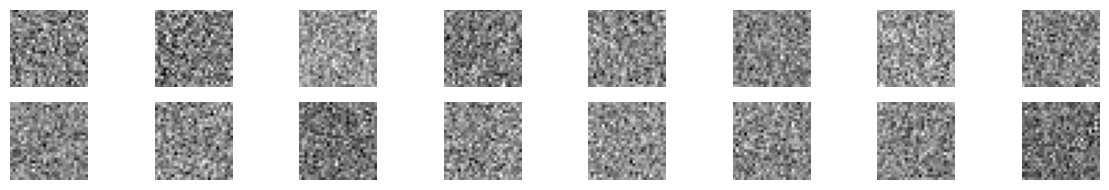

In [24]:
C, H, W = (1, 28, 28)  # MNIST images are 28x28
img = torch.randn(16, C, H, W, device=unet_1.device)
for t in reversed(range(ddpm1.scheduler.timesteps)):
    t_batch = torch.full((16,), t, device=unet_1.device, dtype=torch.long)
    pred_noise_1 = unet_1(img, t_batch).sample.detach()
    pred_noise_2 = unet_2(img, t_batch).sample.detach()
    composite_noise = -torch.stack([pred_noise_1, pred_noise_2], dim=0) # shape: (2, 16, 1, 28, 28)
    # composite_noise = (pred_noise_1 + pred_noise_2) / 2
    composite_noise = torch.logsumexp(composite_noise, dim=0)  # log-sum-exp trick for better numerical stability
    # composite_noise = pred_noise_2
    img = ddpm1.scheduler.step(composite_noise, t, img)
# clamp to [-1,1], convert to [0,1]
img.clamp(-1,1)
# display the composite image
fig, ax = plt.subplots(2, 8, figsize=(12, 2))
for i in range(16):
    ax[i//8, i%8].imshow(img[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5, cmap='gray')
    ax[i//8, i%8].axis('off')
plt.tight_layout()
plt.show()

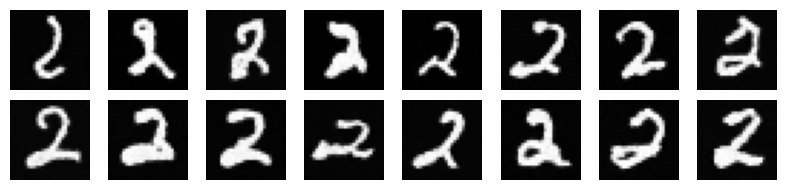

In [14]:
ddpm2.eval()
samples = ddpm2.sample(batch_size=16, image_dim=(1, 28, 28))
# display samples
fig, axes = plt.subplots(2, 8, figsize=(8, 2))
for i in range(16):
    axes[i//8, i%8].imshow(samples[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5, cmap='gray')
    axes[i//8, i%8].axis('off')
plt.tight_layout()
plt.show()

torch.Size([8, 10, 1, 28, 28])


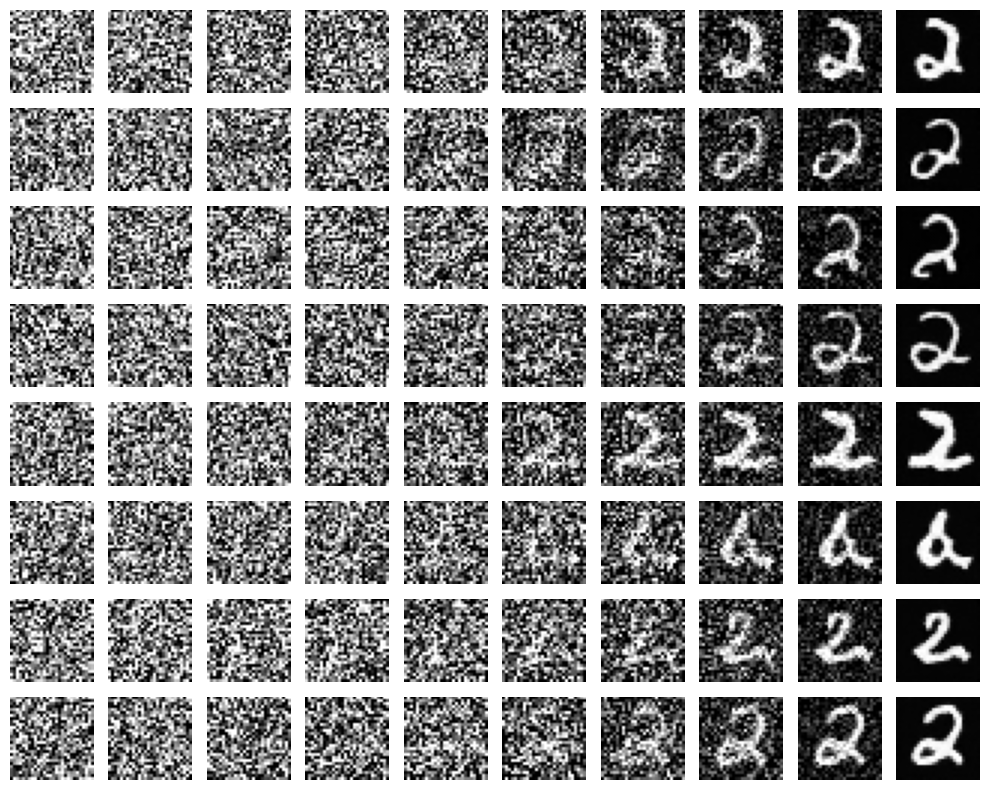

In [42]:
ddpm2.eval()
samples = ddpm2.sample_interval(batch_size=8, image_dim=(1, 28, 28))
print(samples.shape)
# display samples, each column is a timestep, each row is a sample
fig, axes = plt.subplots(8, 10, figsize=(10, 8))
for i in range(8):
    for j in range(10):
        axes[i, j].imshow(samples[i, j].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5, cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# train on full model

Epoch 1/20: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s, loss=0.0346]


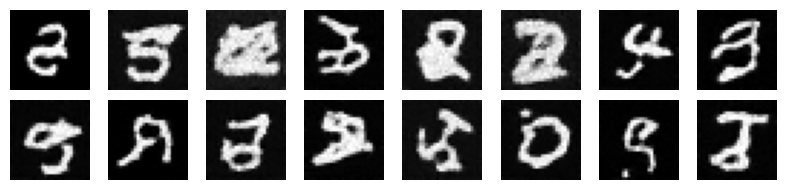

Epoch 2/20: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s, loss=0.0288]


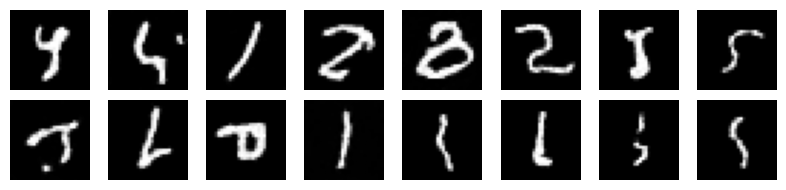

Epoch 3/20: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s, loss=0.0312]


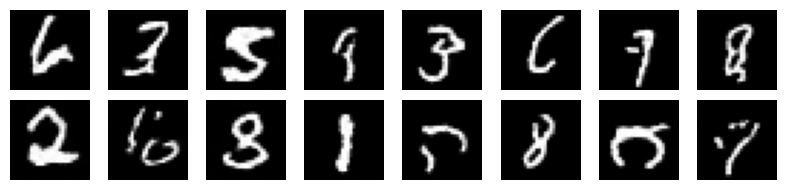

Epoch 4/20: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s, loss=0.0254]


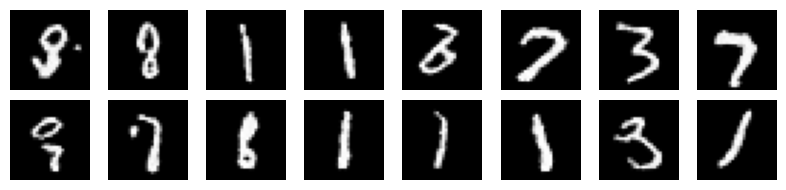

Epoch 5/20: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s, loss=0.0257]


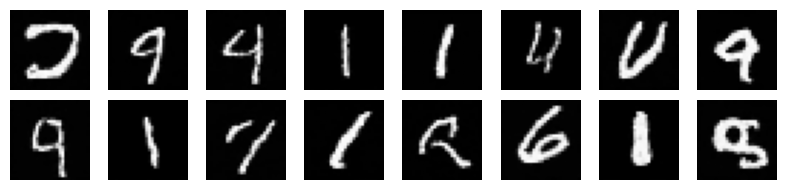

Epoch 6/20: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s, loss=0.0247]


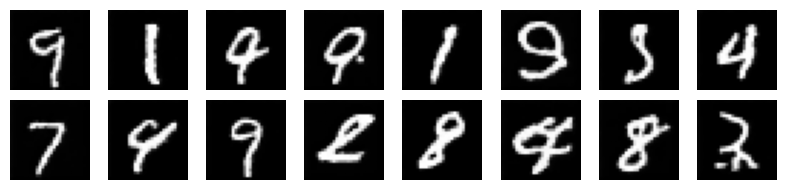

Epoch 7/20: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s, loss=0.0238]


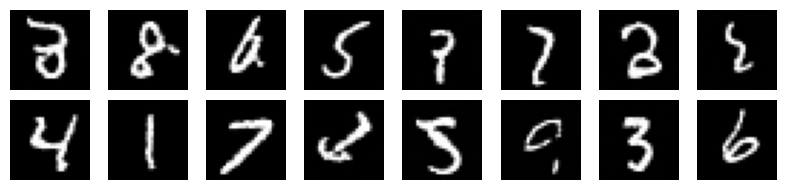

Epoch 8/20: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s, loss=0.024] 


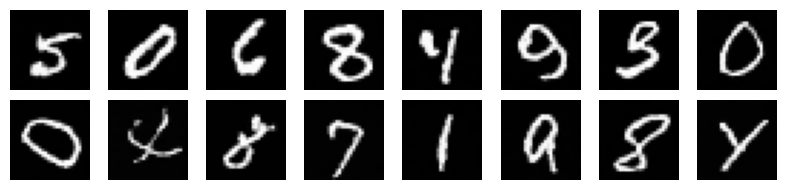

Epoch 9/20: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s, loss=0.0229]


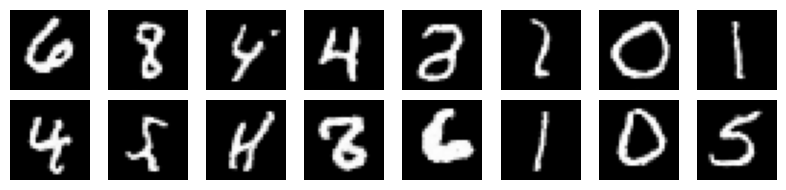

Epoch 10/20: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s, loss=0.0232]


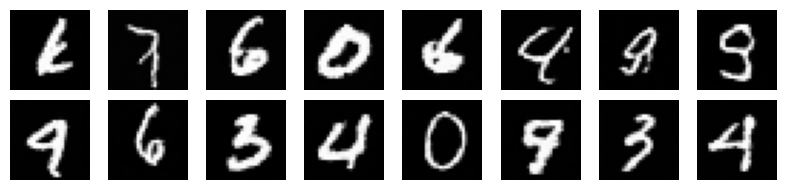

Epoch 11/20: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s, loss=0.0231]


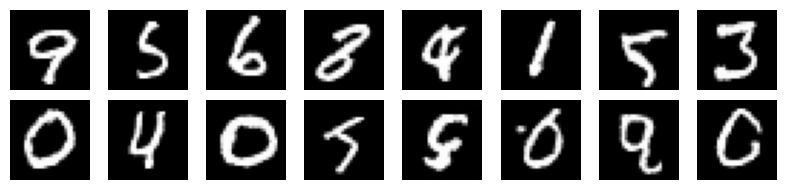

Epoch 12/20: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s, loss=0.0225]


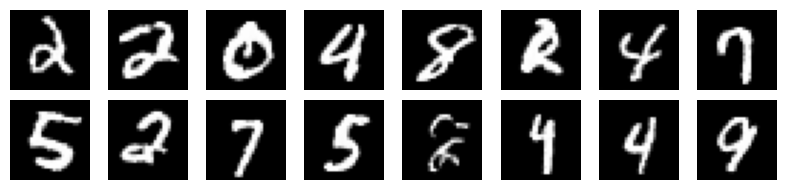

Epoch 13/20: 100%|██████████| 469/469 [00:32<00:00, 14.57it/s, loss=0.023] 


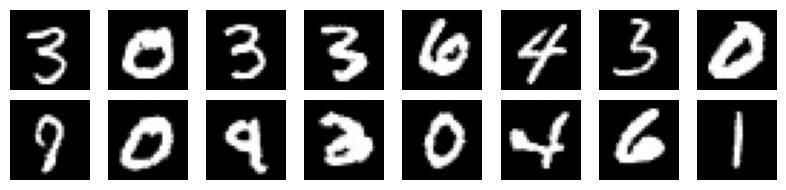

Epoch 14/20: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s, loss=0.0222]


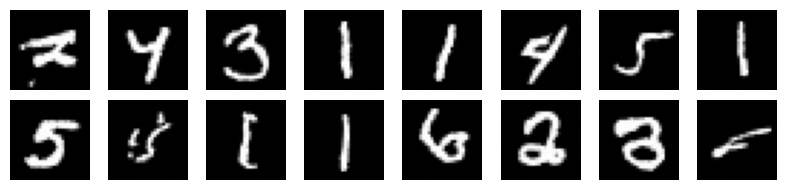

Epoch 15/20: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s, loss=0.0235]


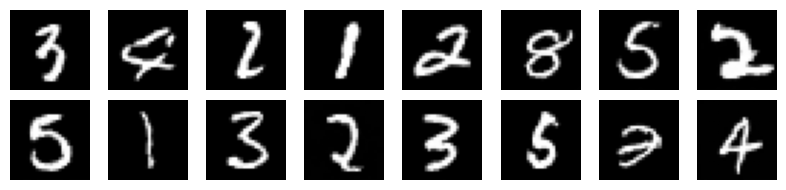

Epoch 16/20: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s, loss=0.0222]


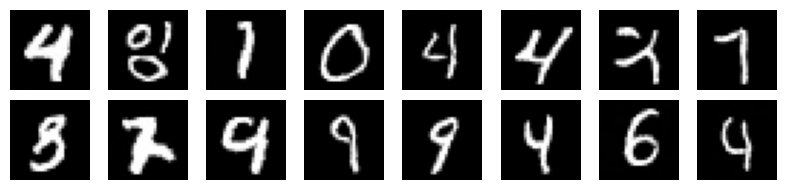

Epoch 17/20: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s, loss=0.0231]


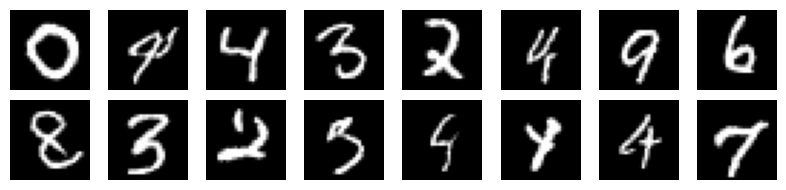

Epoch 18/20: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s, loss=0.023] 


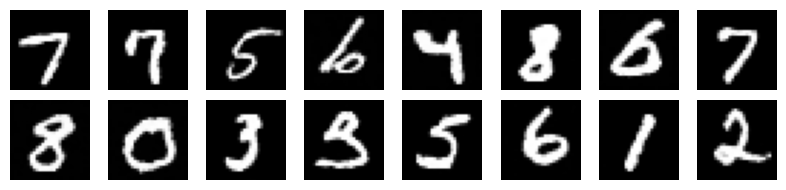

Epoch 19/20: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s, loss=0.0221]


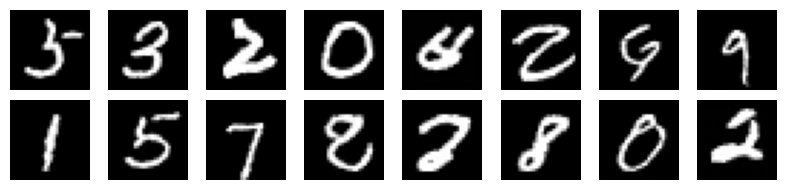

Epoch 20/20: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s, loss=0.0221]


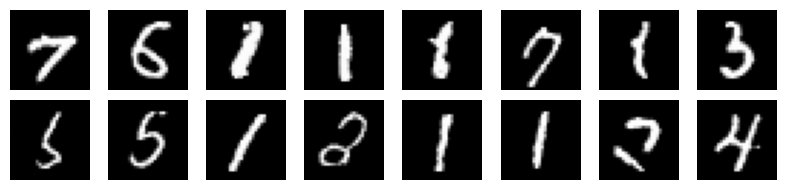

In [40]:
ddpm_scheduler = NoiseScheduler(timesteps=1000, device=device)
unet = UNet2DModel(
    sample_size=28, # MNIST images are 28x28
    in_channels=1,
    out_channels=1,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    layers_per_block=2,
    norm_num_groups=8
)
ddpm = DDPM(unet, ddpm_scheduler, device=device)

train(ddpm, train_dataset)

torch.Size([10, 8, 1, 28, 28])


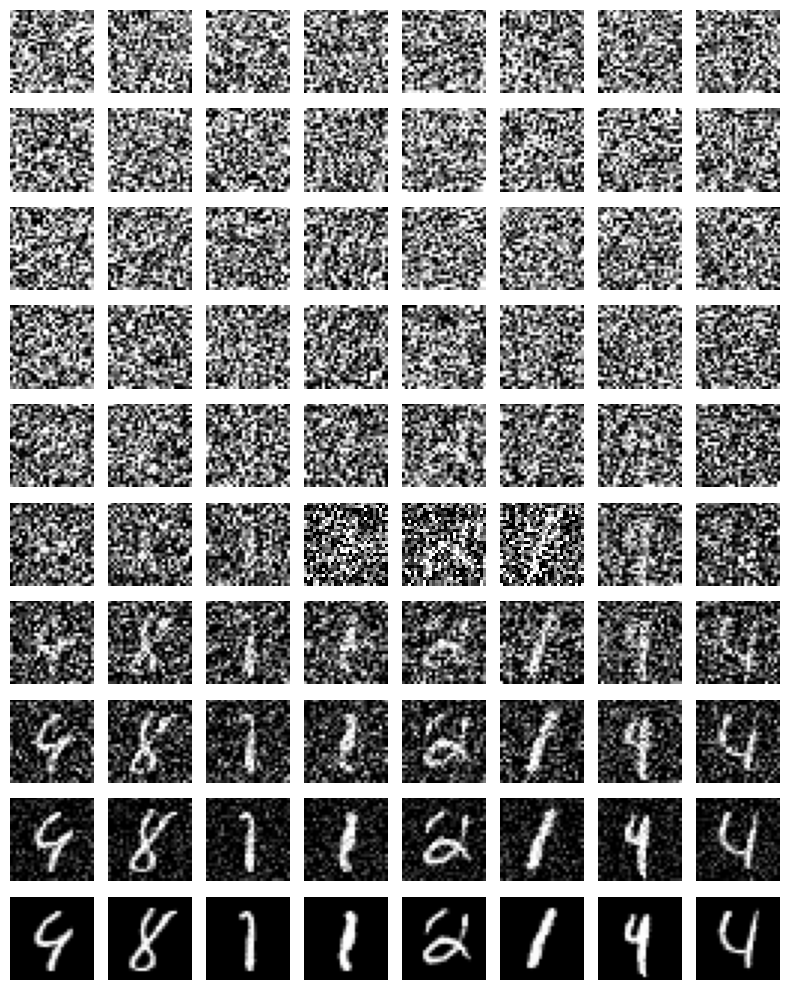

In [45]:
ddpm.eval()
samples = ddpm.sample_interval(batch_size=8, image_dim=(1, 28, 28))
print(samples.shape)
# display samples, each column is a timestep, each row is a sample
fig, axes = plt.subplots(10, 8, figsize=(8, 10))
for i in range(10):
    for j in range(8):
        axes[i, j].imshow(samples[i, j].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5, cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()